<a href="https://colab.research.google.com/github/gbwiersum/CLApartmentScraper/blob/main/CLScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import random

from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [27]:
#!apt update
#!apt upgrade
!pip install selenium -q
!apt install chromium-chromedriver -y -q
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import datetime
import re

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



# Defining methods
building the scraping engine. 


1.   Gets each page of listings
2.   For each page of listings, gets attributes and headline descriptions, sqft, rent and a url for the posting.
3. For each url, opens and scrapes all information.



In [452]:
# Open a browser instance.
def start_browser(headless = True):
  chrome_options = webdriver.ChromeOptions()
  if headless:
    chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  webbrowser = webdriver.Chrome('chromedriver', options=chrome_options)
  if not headless:
    webbrowser.set_window_size(48, 32)
  return webbrowser


#Gets all listings for a given search query. If I had a main, this would be it.
#Pages come in batches of 120. Pass "-1" to pages for all.
def get_listings(start_url, results=-1, cooldown=0):
  browser.get(start_url)
  result_dict = {}
  if results == -1:
    end = int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text)
  else:
    end = min([int(BeautifulSoup(browser.page_source).find('span', class_='totalcount').text), results])

  for n in range(0, end, 120):
      if n>0:
        browser.get((start_url+'?s='+str(n)))
      else:
        time.sleep(cooldown)
        browser.get(start_url)

      #Debug:
      pagestart = BeautifulSoup(browser.page_source).find('span', class_='rangeFrom').text
      pageend = BeautifulSoup(browser.page_source).find('span', class_='rangeTo').text
      print("Processing: "+pagestart+" through " + pageend)
      #####

      listings = browser.find_elements(by=By.CLASS_NAME, value='result-info')
      for l in listings:
        html = l.get_attribute('innerHTML')
        attributes = get_listing_attributes(html)
        result_dict.update(attributes)

  final = pd.DataFrame.from_dict(result_dict, orient = 'index')
  final.columns = ['heading', 'url', 'rent', 'date posted', 'beds', 'sqft']
  return(final)

#Rewriting results page into dictionary format
#Takes html string of individual search result, returns dictionary with CL unique ID as index.
def get_listing_attributes(html):
    url = BeautifulSoup(html).a.get('href')

    try:
      price = BeautifulSoup(html).find('span', class_="result-price").text
    except:
      price = None
    
    date = BeautifulSoup(html).find('time', class_="result-date").get('datetime')

    try:
      bed = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, after='br')
      bed = int(bed)
    except:
      bed=0

    try:
        sqft = xml_getter(BeautifulSoup(html).find('span', class_="housing").text, before="", after="ft2")
        sqft = int(sqft)
    except:
        sqft=None

    heading = BeautifulSoup(html).find('a', class_="result-title hdrlnk").text
    id = BeautifulSoup(html).find('a', class_='result-title hdrlnk').get('data-id')

    return({id:[heading, url, price, date, bed, sqft]})


#utility to pull variables out of xml data using leading and following tag.
#I refusue to learn regex and this is my workaround for that.
def xml_getter(text, before="", after=""):
  m = re.search(before+'(.+?)'+after, text)
  if m:
      found = m.group(1).strip()
      return(found)


# Performing Scraping

In [453]:
listingdf = get_listings('https://chicago.craigslist.org/search/apa', results=-1, cooldown=2)

Processing: 1 through 120
Processing: 121 through 240
Processing: 241 through 360
Processing: 361 through 480
Processing: 481 through 600
Processing: 601 through 720
Processing: 721 through 840
Processing: 841 through 960
Processing: 961 through 1080
Processing: 1081 through 1200
Processing: 1201 through 1320
Processing: 1321 through 1440
Processing: 1441 through 1560
Processing: 1561 through 1680
Processing: 1681 through 1800
Processing: 1801 through 1920
Processing: 1921 through 2040
Processing: 2041 through 2160
Processing: 2161 through 2280
Processing: 2281 through 2400
Processing: 2401 through 2520
Processing: 2521 through 2640
Processing: 2641 through 2760
Processing: 2761 through 2880
Processing: 2881 through 3000


In [460]:
browser = start_browser()
def pull_html(url, cooldown=0):
  try:
    browser.get(url)
    html = BeautifulSoup(browser.page_source)
    if html.header is None:
      return None
    elif 'blocked' in html:
      return None
    elif 'Page Not Found' in html.text:
      return "invalid url"
    else:
      time.sleep(cooldown)
      return html
  except:
    return None


def fetch_blank_listings(listingdf):
  #browser = start_browser()
  browser.get(listingdf['url'][0])
  tester = browser.page_source
  if len(tester)>1000:
    nans = listingdf[listingdf['html'].isna()]['url'].apply(lambda x: pull_html(x, cooldown=2))
    return(nans)
  else:
    print("failed to fetch first listing")
    print(BeautifulSoup(browser.page_source))


def parse_listing_html(page_source):
  #page_source = listingdf['html'][0]
  #if True:
  text=None
  attrvals = []
  if page_source is not None:
    try:
      text = str(page_source.find_all('p', class_='attrgroup')[0])
    except IndexError:
      text = None
    except TypeError:
      text = None

  if text is not None:
    #baths, description body, latitude and longitude
    bedbath = BeautifulSoup(text).find('span', class_='shared-line-bubble').text
    baths = xml_getter(bedbath, before="/ ", after='Ba')
    body = str(page_source.find('section', id='postingbody').text).strip()

    try:
      map_data = str(page_source.find_all('div', id='map')[0])
      lat = xml_getter(map_data, before='data-latitude="', after='" ')
      lon = xml_getter(map_data, before='data-longitude="', after='" ')
    except IndexError:
      lat=None
      lon=None
    attrvals.extend([baths,body,lat,lon])

    #Dogs/cats allowed, laundry situation:
    attrtext = page_source.find_all("p", class_='attrgroup')[1].text

    park = re.search('\n(.+?)'+"park"+'(.+?)\n', attrtext)
    dog = re.search('\n'+'dog'+'(.+?)\n', attrtext)
    cat = re.search('\n'+'cat'+'(.+?)\n', attrtext)
    laundry = re.search('\n'+'laundry'+'(.+?)\n', attrtext)

    attrs = [park, dog, cat, laundry]
    for n in attrs:
      if n is None:
        attrvals.append('None')
      else:
        attrvals.append(n.group(0).strip())

    return attrvals

  else:
    return None

#Takes HTML of a listing. Returns a list of attributes - those not listed in top-line search results.
#columns = ['baths', 'body', 'lat', 'lon', 'parking', 'dogs', 'cats', 'laundry']

In [455]:
#Pull listings html:
listingdf['html']=listingdf['url'].apply(lambda x: pull_html(x, cooldown=5))


In [458]:
listingdf[listingdf['html']==None]

,heading,url,rent,date posted,beds,sqft,html


In [415]:
#Fill in the blanks:
def fetch_blank_listings(listingdf):
  browser = start_browser()
  browser.get(listingdf['url'][0])
  tester = browser.page_source
  if len(tester)>1000:
    nans = listingdf[listingdf['html'].isna()]['url'].apply(lambda x: pull_html(x, cooldown=2))
    return(nans)
  else:
    print("failed to fetch first listing")
    print(BeautifulSoup(browser.page_source))

In [461]:

parsed = listingdf.apply(lambda x: parse_listing_html(x['html']), axis='columns', result_type='expand')
parsed.columns = ['baths', 'body', 'lat', 'lon', 'parking', 'dogs', 'cats', 'laundry']
listingdf = listingdf.join(parsed)
listingdf

,heading,url,rent,date posted,beds,sqft,html,baths,body,lat,lon,parking,dogs,cats,laundry
7494215544,2 Bedroom 2 Bath condo for rent,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,375",2022-06-09 06:01,2,1200.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nSpacious 2 bedr...,41.975931,-87.695907,off-street parking,None,None,laundry in bldg
7494207065,Single Family Residence,https://chicago.craigslist.org/chc/apa/d/lemon...,"$2,000",2022-06-09 04:20,4,1938.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nOne of the most...,41.663930,-88.003759,None,dogs are OK - wooof,cats are OK - purrr,None
7494199086,"FULLY FURNISHED 3 Bedroom, 2 Bathroom Apartmen...",https://chicago.craigslist.org/chc/apa/d/chica...,"$2,995",2022-06-09 01:53,3,1200.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2,QR Code Link to This Post\n\n\nFULLY FURNISHED...,41.848600,-87.631998,None,dogs are OK - wooof,cats are OK - purrr,None
7494195822,"Luxury, Spacious Residence in Englewood!!!",https://chicago.craigslist.org/chc/apa/d/chica...,"$1,800",2022-06-09 01:11,5,1600.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,"QR Code Link to This Post\n\n\nThis spacious, ...",41.760900,-87.643000,street parking,None,None,laundry on site
7494183805,2 bedroom apt available for rent,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,400",2022-06-08 23:26,2,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\n5 room apartmen...,41.997320,-87.787905,off-street parking,None,None,laundry in bldg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487173324,Fully Furnished Studio Apartment,https://chicago.craigslist.org/chc/apa/d/chica...,"$2,190",2022-05-23 07:12,1,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nFurnished Studi...,41.781400,-87.770500,off-street parking,dogs are OK - wooof,cats are OK - purrr,laundry on site
7487153830,Alquiler/Arrendamiento con Derecho a Compra,https://chicago.craigslist.org/sox/apa/d/osweg...,"$3,220",2022-05-23 04:47,4,3000.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2.5,QR Code Link to This Post\n\n\nComuníquese con...,41.684900,-88.345300,None,dogs are OK - wooof,cats are OK - purrr,None
7487153499,Rent/Lease With Right To Purchase,https://chicago.craigslist.org/sox/apa/d/osweg...,"$3,220",2022-05-23 04:41,4,3000.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",2.5,QR Code Link to This Post\n\n\nContact me to l...,41.684900,-88.345300,None,dogs are OK - wooof,cats are OK - purrr,None
7487125200,all include.1B1B+den. Lakeview high rise condo...,https://chicago.craigslist.org/chc/apa/d/chica...,"$2,200",2022-05-22 22:49,1,830.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1,QR Code Link to This Post\n\n\nBeautiful 1b1b ...,41.856584,-87.619323,None,dogs are OK - wooof,cats are OK - purrr,None


In [451]:
nans = pd.DataFrame(listingdf.loc[listingdf.html.isna()])
nans['html'] = nans['url'].apply(lambda x: pull_html(x))
listingdf.fillna(nans)

,heading,url,rent,date posted,beds,sqft,html
7493094819,"Edgewater 2 bedroom 2 bath, gym, 1 block from ...",https://chicago.craigslist.org/chc/apa/d/chica...,"$2,500",2022-06-06 13:55,2,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont..."
7493094613,Outdoor space and Old World charm in a 2-bedro...,https://chicago.craigslist.org/chc/apa/d/chica...,"$2,195",2022-06-06 13:54,2,1000.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont..."
7493090661,Location! Heat Included! Updated Kitchen! Read...,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,065",2022-06-06 13:47,1,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont..."
7493089190,For rent July 1,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,295",2022-06-06 13:44,2,1000.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont..."
7493088874,"Open kitchen. In-unit W/D. Garage avail, free ...",https://chicago.craigslist.org/chc/apa/d/chica...,"$1,850",2022-06-06 13:44,2,NaN,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont..."
...,...,...,...,...,...,...,...
7485397986,Apply Today!!,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,395",2022-05-18 16:12,0,NaN,NaN
7485397702,Greektown studio near UIC!,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,475",2022-05-18 16:12,0,NaN,NaN
7485397227,Huge West Loop Studio! Available in August - S...,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,495",2022-05-18 16:11,0,NaN,NaN
7485396995,Corner Unit on Adams & Wells!,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,775",2022-05-18 16:10,1,NaN,NaN


In [450]:
listingdf[listingdf['html'].isna()]

,heading,url,rent,date posted,beds,sqft,html
7493072015,1 Bedroom Oak Park. Heat Included,https://chicago.craigslist.org/wcl/apa/d/oak-p...,"$1,200",2022-06-06 13:13,1,NaN,NaN
7493069353,2 Bedroom Wrigleyville. Parking Available,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,950",2022-06-06 13:08,2,NaN,NaN
7493066354,"1BR, 1BA Apartment for Rent",https://chicago.craigslist.org/chc/apa/d/chica...,"$1,275",2022-06-06 13:03,1,NaN,NaN
7493063430,Heat Included! Small Dog Ok! Updated Kitchen W...,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,150",2022-06-06 12:58,2,NaN,NaN
7493062900,Beautiful and Sunny 1 bdr in Ravenswood. Avail...,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,199",2022-06-06 12:57,1,NaN,NaN
...,...,...,...,...,...,...,...
7485397986,Apply Today!!,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,395",2022-05-18 16:12,0,NaN,NaN
7485397702,Greektown studio near UIC!,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,475",2022-05-18 16:12,0,NaN,NaN
7485397227,Huge West Loop Studio! Available in August - S...,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,495",2022-05-18 16:11,0,NaN,NaN
7485396995,Corner Unit on Adams & Wells!,https://chicago.craigslist.org/chc/apa/d/chica...,"$1,775",2022-05-18 16:10,1,NaN,NaN


In [524]:
listingdf['Dpsf']=listingdf['rent']/listingdf['sqft']

In [534]:
listingdf[listingdf['Dpsf']==listingdf['Dpsf'].max()]

,heading,url,rent,date posted,beds,sqft,html,baths,body,lat,lon,parking,dogs,cats,laundry,Dpsf
7493052191,ROOMMATE | BEDROOM & OFFICE IN 2 BEDROOM DUPLE...,https://chicago.craigslist.org/chc/apa/d/chica...,1300,2022-06-06 12:38,2,112.0,"[[[\n, <meta charset=""utf-8""/>, \n, <meta cont...",1.5,QR Code Link to This Post\n\n\nAvailable is on...,41.909930,-87.638830,None,None,None,None,11.607143


In [463]:
version = datetime.date.today().strftime("%y%m%d")
listingdf.to_csv('./'+version+'cl-scraped.csv')

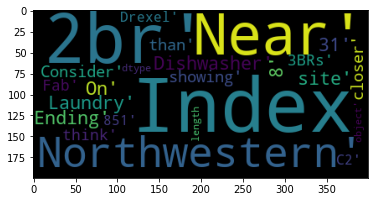

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
cloud = WordCloud().generate(str(words.keys()))
plt.imshow(cloud)

In [464]:
listingdf["heading"]=listingdf["heading"].apply(lambda x: clean(x))
heading_dummies = listingdf["heading"].str.get_dummies(sep=" ")
listingdf.set_index('key').join(heading_dummies.set_index('key'))

[nltk_data] Downloading package stopwords to /Users/grant/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [477]:
def clean(heading):
  heading = heading.replace('QR Code Link to This Post\n\n\n', "")
  heading = heading.replace("\n", "")
  heading = re.sub('[^0-9a-zA-Z]+', " ", heading)
  heading = heading.lower()
  return(heading)

In [478]:
clean(listingdf['body'][0])

'spacious 2 bedroom 2 bath condo for rent in lincoln square parking space included in the rent dishwaher ceiling fans air conditioning carpeted throughout plenty of closets one block to tonys food mart and walgreens laundry facility on site storage unit in the basement renter pays all utilities except water no pets cretic check required call joe at 773 728 7479'

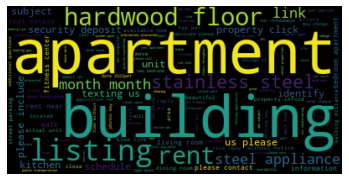

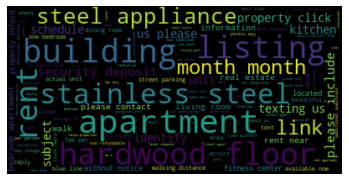

In [479]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
text = " ".join(clean(str(i)) for i in listingdf['body'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
#df=pd.read_csv('./CLScraped.csv')
dummy = df[['rent','sqft', 'beds', 'baths', 'parking', 'lat', 'lon', 'dogs', 'cats', 'laundry']]
dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
dummy['beds']=dummy['beds']/max(dummy['beds'])
dummy['dogs'].fillna(0, inplace=True)
dummy['dogs'].replace("dogs are OK - wooof", 1, inplace=True)
dummy['cats'].fillna(0, inplace=True)
dummy['cats'].replace('cats are OK - purrr', 1, inplace = True)
dummy['laundry'].replace('laundry in bldg', 1, inplace=True)
dummy["laundry"].replace('laundry on site', 1, inplace=True)
dummy['laundry'].fillna(0, inplace=True)
dummy[dummy['parking'].notnull()]['parking']=1
dummy['parking'].fillna(0, inplace=True)
dummy['sqft'].replace(0, None)

#########delete this later
def fixbaths(text):
  m = re.search('/ (.+?)', text)
  return(float(m.group(1)))
dummy['baths']=dummy['baths'].apply(lambda x: fixbaths(x))
#########

dummy['baths']=dummy['baths']/max(dummy['baths'])

dummy = dummy.drop(columns=['sqft', 'parking'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

In [ ]:
dummy

,rent,beds,baths,lat,lon,dogs,cats,laundry
0,0.000000,0.00,0.5,42.000875,-87.662074,0,1,1.0
1,0.125000,0.00,0.5,41.930603,-87.640901,0,1,1.0
2,0.304688,0.00,0.5,41.743400,-87.980500,1,1,1.0
3,0.742188,1.00,1.0,41.928719,-87.646093,0,0,0.0
4,0.146875,0.25,0.5,41.913120,-87.702463,0,1,1.0
5,0.459375,0.25,0.5,41.893832,-87.641509,0,0,0.0
6,0.507812,0.75,0.5,41.798852,-87.596749,1,1,1.0
7,0.304688,0.00,0.5,41.743400,-87.980500,1,1,1.0
8,0.242188,0.50,1.0,41.848532,-87.678153,1,1,0.0
9,0.359375,0.50,0.5,41.971900,-87.662400,0,1,0.0


In [485]:
listingdf['rent']=listingdf['rent'].apply(lambda x: int(x.replace("$", "").replace(",", "")))

In [496]:
def fix_baths(x):
  if x is None:
    return 0
  else:
    try:
      return float(x)
    except:
      return(0)

listingdf['baths'] = listingdf['baths'].apply(lambda x: fix_baths(x))

In [535]:
#df=pd.read_csv('./CLScraped.csv')
dummy = listingdf[['rent','sqft', 'beds', 'baths', 'parking', 'lat', 'lon', 'dogs', 'cats', 'laundry']]
dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
dummy['beds']=dummy['beds']/max(dummy['beds'])
dummy['dogs'].replace(None, inplace=True)
dummy['dogs'].replace("dogs are OK - wooof", 1, inplace=True)
dummy['cats'].replace(None, inplace=True)
dummy['cats'].replace('cats are OK - purrr', 1, inplace = True)
dummy[dummy['parking'].notnull()]['parking']=1
dummy['parking'].fillna(0, inplace=True)
dummy['sqft'].replace(0, None)
dummy['baths'] = dummy['baths'].apply(lambda x: x/max(dummy['baths']))
dummy['dpsf'] = (listingdf['Dpsf']-listingdf['Dpsf'].mean())/listingdf['Dpsf'].std()
dummy = dummy.join(pd.get_dummies(dummy['parking'])).drop(columns='parking')


<ipython-input-535-c6d007dddce0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy['rent'] = dummy['rent'].apply(lambda x: (x-min(dummy['rent']))/(max(dummy['rent'])))
<ipython-input-535-c6d007dddce0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy['beds']=dummy['beds']/max(dummy['beds'])
/Users/grant/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [545]:
dummy[['lat', 'lon']].fillna(0, inplace = True)
dummy['lat'].apply(lambda x: float(x))

/Users/grant/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


TypeError: float() argument must be a string or a number, not 'NoneType'

'41.975931'

<AxesSubplot:>

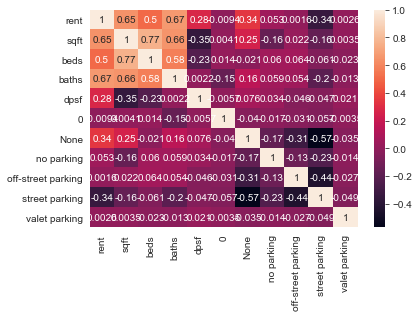

/Users/grant/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/grant/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='sqft', ylabel='rent'>

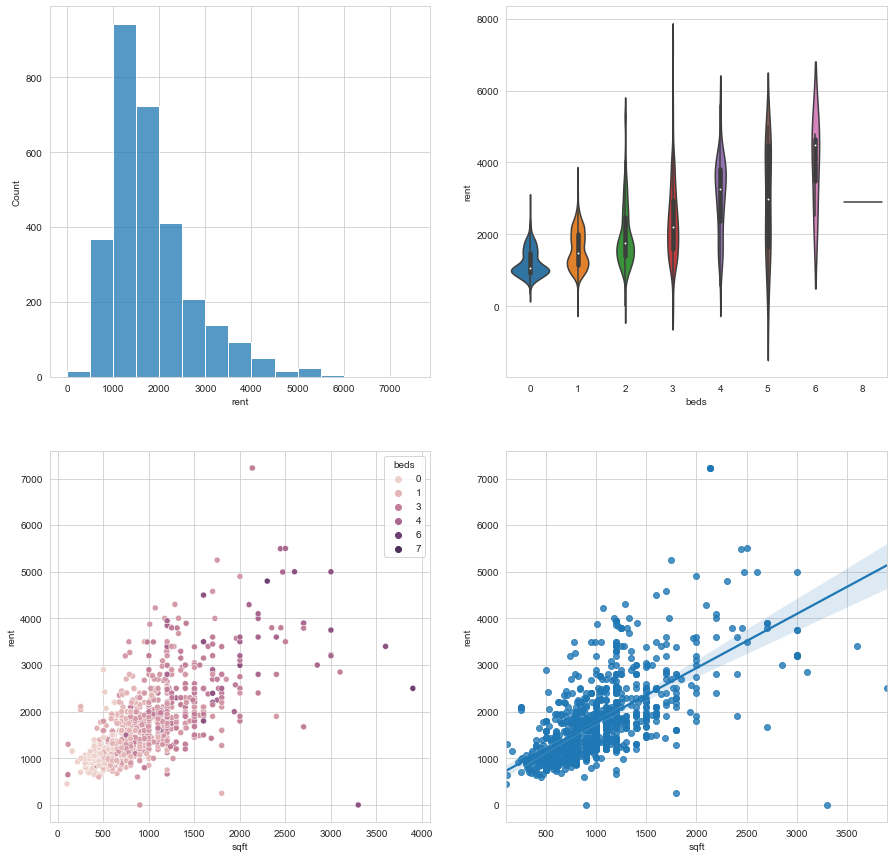

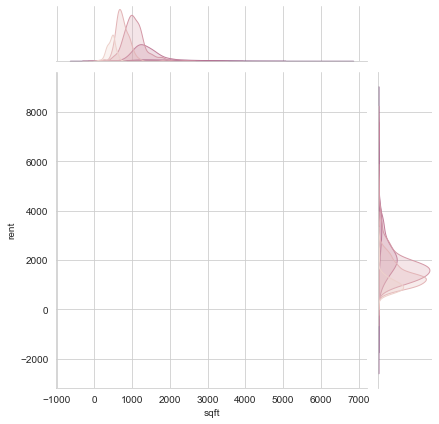

In [516]:
import seaborn as sns
import matplotlib.pyplot as plt
 
fig, axes = plt.subplots(2,2 , figsize=(15, 15))
sns.histplot(ax=axes[0,0], data=listingdf['rent'], binwidth=500)
sns.violinplot(ax=axes[0,1], x=listingdf["beds"], y=listingdf["rent"])
sns.jointplot(ax=axes[1,0], x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['rent'], hue=listingdf['beds'])
sns.regplot(ax=axes[1,1], x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['rent'])

In [518]:
from scipy.stats import linregress
slope, intercept, r, p, se = linregress(x=listingdf[listingdf['sqft']>0]['sqft'], y=listingdf[listingdf['sqft']>0]['rent'])

In [521]:
print(str(slope)+"*X+"+str(intercept)+"\nr="+str(r)+"\np="+str(p))

1.158199817977743*X+619.6434652745438
r=0.6460643723301506
p=3.678039597230272e-114


In [ ]:

#For scraping historical data:

for i in links:
	soup = BeautifulSoup(requests.get(i).content, 'html.parser')
	date_plus = str(soup).split("web/",1)[1].split("/http",1)[0]
	historic_scrape(0,soup,date_plus)
	print("***** Link" + str(i) + "completed *****")

def get_links(years=["2020", "2021", "2022"]):

  # List the years you'll loop over
  years = ["2020", "2021", "2022"]
  # And instantiate a list we'll put links in
  linklist = []

  for y in years:
    try:
      calpage = "https://web.archive.org/web/" + str(y) + "0101000000*/http://www.chicago.craigslist.org/search/apa"
      browser.get(calpage)  # doing this twice ensures that it loads correctly
      browser.get(calpage)
      time.sleep(1)
      try:
        cal = browser.find_elements(by=By.CLASS_NAME, value='calendar-day')
      except:
        time.sleep(3) # sometimes the browser loads slowly--just try again
        cal = browser.find_elements(by=By.CLASS_NAME, value='calendar-day')
      for c in cal:
        html = c.get_attribute("innerHTML") # get the calendar's html content
        soup = BeautifulSoup(html, 'html.parser') # turn it into a soup
        link = str(soup.a) # the name of the chunk containing links
        url = "https://web.archive.org" + link.split('"', 1)[1].split('"',1)[0]
        if url not in linklist: # if we don't already have it, add it to the list
          linklist.append(url)
    except:  # if a page does not exist, continue to the next one
      continue
  return(linklist)

links = get_links()
links.append("https://chicago.craigslist.org/search/apa") #Add current day's listings